In [24]:
# We create a file where all images will be stored

data_dir = './240'
import helper
import math
import os
import sys
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil
import glob

import numpy as np
from PIL import Image
from tqdm import tqdm


In [25]:
print(os.getcwd())

/home/ubuntu/poster_generator


In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np
import os

def prepare_data(img_dir):

    image_dirs = np.array([dirpath for (dirpath, dirnames, filenames) in gfile.Walk(os.getcwd()+'/'+img_dir)])
    file_list = []
    y_= []
# Ignoring the first directory as it is the base directory
    for image_dir in image_dirs[1:]:
            extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
            dir_name = os.path.basename(image_dir)
            image_file_list =[]
            tf.logging.info("Looking for images in '" + dir_name + "'")
            for extension in extensions:
                # Building the filename pattern
                file_glob = os.path.join(image_dir,'*.' + extension)
                #This looks for a file name pattern, helps us ensure that only jpg extensions are choosen
                image_file_list = gfile.Glob(file_glob)
                file_list.extend(image_file_list)
                y_.extend([dir_name]*len(image_file_list))

    return file_list,y_



def read_image_array(image_loc_array):
    resized_image_array=[]

    for image_loc in image_loc_array:
        image_decoded = tf.image.decode_jpeg(tf.gfile.FastGFile(image_loc, 'rb').read(),channels=3)
        resized_image = tf.reshape(tf.image.resize_images(image_decoded, [28,28]),[1,28*28*3])
        resized_image_array.append(resized_image)

    resized_image_array = tf.reshape(tf.stack(resized_image_array),[len(image_loc_array),28*28*3])
    return resized_image_array





def read_single_image(image_loc):
    image_decoded = tf.image.decode_jpeg(tf.gfile.FastGFile(image_loc, 'rb').read(),channels=3)
    resized_image = tf.reshape(tf.image.resize_images(image_decoded, [28,28]),[1,28*28*3])
    return resized_image

In [23]:
from PIL import Image
import os
import glob

# NOTE
# Helper Cell Create Thumbnail fith images


# TODO: Get images from ./data recursively.
# data_dir = '.'
# size = (240, 240)

# for f in os.listdir('.'):
#     if f.endswith('.jpg'):
#         i = Image.open(f)
#         rgb_im = i.convert('RGB')
#         rgb_im.save(f)
#         i = Image.open(f)
#         i.thumbnail(size, Image.ANTIALIAS)
#         fn, fext = os.path.splitext(f)
#         i.save('240/{}240{}'.format(fn, fext))



In [31]:
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

#     if image.size != (width, height):  # HACK - Check if image is from the poster dataset
        # Remove most pixels that aren't part of a face
#         face_width = face_height = 108
#         j = (image.size[0] - face_width) // 2
#         i = (image.size[1] - face_height) // 2
#         image = image.crop([j, i, j + face_width, i + face_height])
    image = image.resize([width, height], Image.ANTIALIAS)

    return np.array(image.convert(mode))

In [27]:
def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [28]:
def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

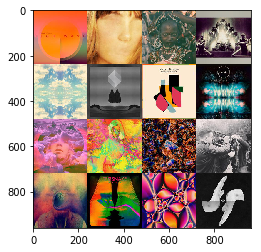

In [32]:
show_n_images = 20


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np
import math

poster_images = get_batch(glob(os.path.join(data_dir, '*.jpg'))[:show_n_images], 240, 240, 'RGB')
pyplot.imshow(images_square_grid(poster_images, 'RGB'))

## Check GPU Version

In [33]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0


/home/ubuntu/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


In [34]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim = (image_width ,image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate

### Discriminator

In [35]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=(2, 2), padding='same')
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # Now 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 4x4x256
        
        # Flatten to 1D tensor
        x = tf.reshape(x, (-1, 4 * 4 * 256))
        # Now 4x4x256
        logits = tf.layers.dense(x, 1)
        output = tf.nn.sigmoid(logits)

        return output, logits



### Generator

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 7 * 7 * 1024)
        # Reshape tensor with -1 to flaten into a 1d
        x = tf.reshape(x, (-1, 7, 7, 256))
        # Batch Norm
        x = tf.layers.batch_normalization(x, training=is_train)
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # now 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 14x14x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 28x28x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=(1, 1), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=(1, 1), padding='same')
        output = tf.tanh(logits)
        # now 28x28x3
        
        return output



### Loss

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

### Optimization

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt




## Neural Network Training

### Show Output

In [39]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build Model    
    # Reset number of steps
    samples, losses = [], []
    steps = 0
    
    # Print training data
    print_every = 10
    show_every = 100
    
    
    # Pass dim 3 or 1 depending if images have color or not
    if (data_image_mode == 'RGB'):
        out_channel_dim=3
    else:
        out_channel_dim=1
    
    
    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
 
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # The values of the Posters dataset will be in the range of -0.5 to 0.5 of 240x240 
                # dimensional images fot fit our random uniform we multiply by 1.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)


        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
        return losses, samples
                
                

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

### Poster

In [46]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


epochs = 1

poster_dataset = helper.Dataset('', glob(os.path.join(data_dir, '/*.jpg')))

# poster_dataset = glob(os.path.join(data_dir, '/*.jpg'))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, poster_dataset.get_batches,
          poster_dataset.shape, poster_dataset.image_mode)

AttributeError: module 'helper' has no attribute 'Dataset'

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with Posters Dataset")
plt.legend()